In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %% minimal bootstrap
import sys, os, subprocess, importlib.util
from pathlib import Path

def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(50):
        if any((p / m).exists() for m in ("pyproject.toml", ".git", "defaults.yaml")):
            return p
        if p == p.parent: break
        p = p.parent
    return start.resolve()

_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    spec = importlib.util.find_spec(pkg_name)
    need = (not spec) or (not getattr(spec, "origin", None)) or (Path(spec.origin).resolve().parents[0] != pkg_dir.resolve())
    if need:
        print(f"Installing {pkg_name} in editable mode from {pkg_dir} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(pkg_dir)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

# %% imports & paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k
from diffinst.analysis_api import (
    load_manifest, load_config_from_run, list_checkpoints, load_metrics,
    load_linear_run, load_linear_Sigma_series, load_linear_amplitude,
    load_nonlinear_run, load_nonlinear_Sigma_series, load_nonlinear_amplitude,
    nearest_k_index, save_ic_npz, evp_gamma
)

EXP_STABLE   = ROOT / "experiments" / "baseline.yaml"
EXP_DIFFSLOPE = ROOT / "experiments" / "diffinst.yaml"
EXP_VISCSLOPE = ROOT / "experiments" / "diffinst_viscslope.yaml"
EXP_OVER = ROOT / "experiments" / "diffover.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

FIGURE_PATH = ROOT / "figures"; FIGURE_PATH.mkdir(exist_ok=True)

print("project root:", ROOT)



diffinst already installed from this repo.
project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


In [3]:
# %% global params & helpers for linear robustness tests

import subprocess
import sys

# Reuse ROOT, EXP_* and RUNS from your setup cell

# Branch mapping: labels → experiment YAMLs
BRANCHES = {
    "stable":    EXP_STABLE,
    "diffslope": EXP_DIFFSLOPE,
    "viscslope": EXP_VISCSLOPE,
    "over":      EXP_OVER,
}

# Global knobs (you can tweak these)
K_MODE      = 100.0      # physical k for eigenmode ICs
NX_IC       = 128        # grid size for ICs and TD runs
IC_AMP      = 1e-4       # small amplitude for linear regime
STOP_TIME   = 50.0       # total integration time (same for all runs, for now)
SAVE_STRIDE = 200        # how often to save checkpoints
PRINT_STRIDE = 400       # for nonlinear/dedalus logging

# Time steps per branch (rough guesses; tweak if needed)
DT_LINEAR = {
    "stable":    1e-2,
    "diffslope": 2e-3,
    "viscslope": 2e-3,
    "over":      2e-3,
}

# Per-branch time step for nonlinear runs (tunable)
DT_NONLIN = {
    "stable":   1e-2,
    "diffslope": 2e-3,
    "viscslope": 2e-3,
    "over": 2e-3,
}


DT_DEDALUS = {
    "stable":    1e-4,
    "diffslope": 1e-4,
    "viscslope": 1e-4,
    "over":      1e-4,
}



# Base run directory for this notebook
RUN_BASE = ROOT / "runs" / "linear_robustness"
RUN_BASE.mkdir(exist_ok=True)

IC_DIR = RUN_BASE / "ics"
IC_DIR.mkdir(exist_ok=True)

# Convenience: per-branch paths for IC and run directories
IC_PATHS = {
    name: IC_DIR / f"ic_{name}_k{int(K_MODE)}.npz"
    for name in BRANCHES.keys()
}

RUN_LIN_NATIVE = {
    name: RUN_BASE / f"{name}_lin_native"
    for name in BRANCHES.keys()
}

RUN_NL_NATIVE = {
    name: RUN_BASE / f"{name}_nl_native"
    for name in BRANCHES.keys()
}

RUN_DED_NL = {
    name: RUN_BASE / f"{name}_dedalus_nl"
    for name in BRANCHES.keys()
}


def run_cmd(cmd: list[str]):
    """Run a CLI command and raise if it fails; print stdout/stderr."""
    print("Running:", " ".join(str(c) for c in cmd))
    result = subprocess.run(cmd, text=True, capture_output=True)
    if result.stdout:
        print(result.stdout)
    if result.stderr:
        print(result.stderr)
    if result.returncode != 0:
        raise RuntimeError(f"Command failed with code {result.returncode}")

In [4]:
# %% build eigenmode ICs for all branches (gas-inclusive configs)

for name, cfg_path in BRANCHES.items():
    ic_path = IC_PATHS[name]
    cmd = [
        sys.executable, "-m", "scripts.make_ic_eigen",
        "--config", str(cfg_path),
        "--out", str(ic_path),
        "--k", str(K_MODE),
        "--amp", str(IC_AMP),
        "--Nx", str(NX_IC),
        "--exact-fit-harm", "2",
    ]
    run_cmd(cmd)

print("Eigenmode ICs written to:")
for name, ic_path in IC_PATHS.items():
    print(f"  {name}: {ic_path}")

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/baseline.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/ics/ic_stable_k100.npz --k 100.0 --amp 0.0001 --Nx 128 --exact-fit-harm 2
[make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/ics/ic_stable_k100.npz (k=100.0, amp=0.0001, Nx=128)

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/ics/ic_diffslope_k100.npz --k 100.0 --amp 0.0001 --Nx 128 --exact-fit-harm 2
[make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/ics/i

In [5]:
# %% run native linear TD for all branches from eigenmode ICs

for name, cfg_path in BRANCHES.items():
    outdir = RUN_LIN_NATIVE[name]
    outdir.mkdir(parents=True, exist_ok=True)

    dt = DT_LINEAR[name]

    cmd = [
        sys.executable, "-m", "scripts.run_linear",
        "--config", str(cfg_path),
        "--outdir", str(outdir),
        "--mode", "linear",
        "--dt", str(dt),
        "--stop-time", str(STOP_TIME),
        "--save-stride", str(SAVE_STRIDE),
        "--init-from", str(IC_PATHS[name]),
        "--force",
    ]
    run_cmd(cmd)

print("Native linear TD runs completed. Output dirs:")
for name, outdir in RUN_LIN_NATIVE.items():
    print(f"  {name}: {outdir}")

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.run_linear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/baseline.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/stable_lin_native --mode linear --dt 0.01 --stop-time 50.0 --save-stride 200 --init-from /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/ics/ic_stable_k100.npz --force
[INFO] Removing existing output directory: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/stable_lin_native
[linear] done: {'t_final': 50.0, 'steps': 5001, 'Nx': 128, 'Lx': 0.12566370614359174}

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.run_linear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/di

In [6]:
# %% run native nonlinear TD for all branches from eigenmode ICs

for name, cfg_path in BRANCHES.items():
    outdir = RUN_NL_NATIVE[name]
    outdir.mkdir(parents=True, exist_ok=True)
    
    dt = DT_NONLIN[name]

    cmd = [
        sys.executable, "-m", "scripts.run_nonlinear",
        "--config", str(cfg_path),
        "--outdir", str(outdir),
        "--mode", "nonlinear",
        "--dt", str(dt),
        "--stop-time", str(STOP_TIME),
        "--save-stride", str(SAVE_STRIDE),
        "--init-from", str(IC_PATHS[name]),
        "--Nx", str(NX_IC),
        "--print-stride", "400",
        "--force",
    ]
    run_cmd(cmd)

print("Native nonlinear TD runs completed. Output dirs:")
for name, outdir in RUN_NL_NATIVE.items():
    print(f"  {name}: {outdir}")

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.run_nonlinear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/baseline.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/stable_nl_native --mode nonlinear --dt 0.01 --stop-time 50.0 --save-stride 200 --init-from /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/ics/ic_stable_k100.npz --Nx 128 --print-stride 400 --force
[INFO] Removing existing output directory: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/linear_robustness/stable_nl_native
[nonlinear] done: {'t_final': 50.0, 'steps': 5001, 'Nx': 128, 'Lx': 0.12566370614359174}

2025-12-09 20:42:41,500 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=400  t=4.000000e+00  dt=1.000e-02
2025-12-09 20:42:41,875 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=800  t=8.000000e+00  dt=1.000e-

In [7]:
# %% run Dedalus TD (nonlinear backend, linear regime amplitudes) for all branches
""""
for name, cfg_path in BRANCHES.items():
    outdir = RUN_DED_NL[name]
    outdir.mkdir(parents=True, exist_ok=True)

    dt = DT_DEDALUS[name]

    cmd = [
        sys.executable, "-m", "scripts.run_nonlinear",
        "--config", str(cfg_path),
        "--outdir", str(outdir),
        "--mode", "nonlinear",
        "--dt", str(dt),
        "--stop-time", str(STOP_TIME),
        "--save-stride", str(SAVE_STRIDE),
        "--init-from", str(IC_PATHS[name]),
        "--Nx", str(NX_IC),
        "--print-stride", str(PRINT_STRIDE),
        "--backend", "dedalus",
        "--force",
        # keep amplitudes tiny so we're in the linear regime;
        # we already encoded that in the IC, so we don't need extra amp flags here.
    ]
    run_cmd(cmd)

print("Dedalus TD runs (linear regime) completed. Output dirs:")
for name, outdir in RUN_DED_NL.items():
    print(f"  {name}: {outdir}")

"""

'"\nfor name, cfg_path in BRANCHES.items():\n    outdir = RUN_DED_NL[name]\n    outdir.mkdir(parents=True, exist_ok=True)\n\n    dt = DT_DEDALUS[name]\n\n    cmd = [\n        sys.executable, "-m", "scripts.run_nonlinear",\n        "--config", str(cfg_path),\n        "--outdir", str(outdir),\n        "--mode", "nonlinear",\n        "--dt", str(dt),\n        "--stop-time", str(STOP_TIME),\n        "--save-stride", str(SAVE_STRIDE),\n        "--init-from", str(IC_PATHS[name]),\n        "--Nx", str(NX_IC),\n        "--print-stride", str(PRINT_STRIDE),\n        "--backend", "dedalus",\n        "--force",\n        # keep amplitudes tiny so we\'re in the linear regime;\n        # we already encoded that in the IC, so we don\'t need extra amp flags here.\n    ]\n    run_cmd(cmd)\n\nprint("Dedalus TD runs (linear regime) completed. Output dirs:")\nfor name, outdir in RUN_DED_NL.items():\n    print(f"  {name}: {outdir}")\n\n'

/Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/diffinst/vis/linear.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  else:


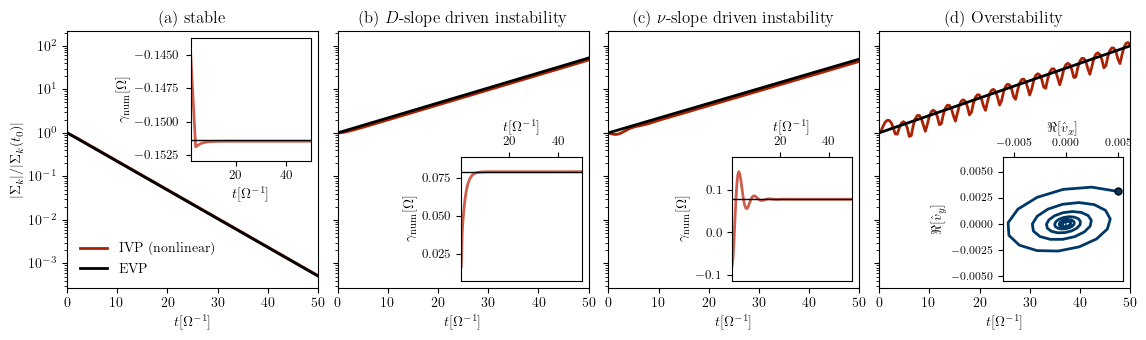

In [14]:
# Example from earlier:
# RUN_IC[name]          – IC paths
# RUN_LIN_NATIVE[name]  – native linear run dirs
# RUN_NL_NATIVE[name]   – native nonlinear run dirs
# RUN_NL_DEDALUS[name]  – Dedalus nonlinear run dirs
#
# with keys like: "stable", "diffslope", "viscslope", "overstable"

# %% assemble branch metadata and plot linear-regime robustness

import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

from diffinst.vis.linear import plot_linear_robustness_with_hodographs

BRANCH_META = {
    "stable": {
        #"run_lin_native": RUN_LIN_NATIVE.get("stable"),
        "run_nl_native":  RUN_NL_NATIVE.get("stable"),
        #"run_nl_dedalus": RUN_DED_NL.get("stable"),
    },
    "diff-slope": {
        #"run_lin_native": RUN_LIN_NATIVE.get("diffslope"),
        "run_nl_native":  RUN_NL_NATIVE.get("diffslope"),
        #"run_nl_dedalus": RUN_DED_NL.get("diffslope"),
    },
    "visc-slope": {
        #"run_lin_native": RUN_LIN_NATIVE.get("viscslope"),
        "run_nl_native":  RUN_NL_NATIVE.get("viscslope"),
        #"run_nl_dedalus": RUN_DED_NL.get("viscslope"),
    },
    "overstable": {
        #"run_lin_native": RUN_LIN_NATIVE.get("over"),
        "run_nl_native":  RUN_NL_NATIVE.get("over"),
       # "run_nl_dedalus": RUN_DED_NL.get("over"),
    },
}

k_phys = 100.0  # or whatever you used for the eigenmode ICs

fig, axes = plot_linear_robustness_with_hodographs(BRANCH_META, k_phys=k_phys, figsize=(11.5, 3.5))

plt.show()

fig.savefig(FIGURE_PATH / "linearevolution_branches.pdf", bbox_inches="tight")

In [10]:
# %% define diffusion-slope experiments (dust vs gas variants)

EXP_DIFF_BASE      = ROOT / "experiments" / "diffinst.yaml"
EXP_DIFF_DUST      = ROOT / "experiments" / "diffinst_dustonly.yaml"
EXP_DIFF_HIGHEPS   = ROOT / "experiments" / "diffinst_higheps.yaml"
EXP_DIFF_LOWNU_G  = ROOT / "experiments" / "diffinst_lowgasvisc.yaml"


K_PHYS_DIFF   = 100.0          # eigenmode wavenumber
AMP_PHYS_DIFF = 1e-5           # very small amplitude (linear regime)
NX_IC_DIFF    = 128

DT_NL_DIFF        = 5e-3
STOP_TIME_NL_DIFF = 50.0
SAVE_STRIDE_NL    = 200

RUN_BASE_DIFF = RUNS / "diff_slope_gas_variants"
RUN_BASE_DIFF.mkdir(exist_ok=True)

DIFF_EXPERIMENTS = {
    "dust":     EXP_DIFF_DUST,
    "fid":      EXP_DIFF_BASE,
    "high_eps": EXP_DIFF_HIGHEPS,
    "low_nu_g": EXP_DIFF_LOWNU_G,
}

# where ICs and nonlinear runs will be written
IC_DIFF = {key: RUN_BASE_DIFF / f"ic_{key}.npz"
           for key in DIFF_EXPERIMENTS.keys()}
RUN_DIFF_NL = {key: RUN_BASE_DIFF / f"nl_{key}"
               for key in DIFF_EXPERIMENTS.keys()}

DIFF_LABELS = {
    "dust":     "dust only",
    "fid":      r"gas, $\varepsilon = 1, \alpha_\mathrm{g} = 10^{-4}$ (fiducial)",
    "high_eps": r"gas, $\varepsilon = 100, \alpha_\mathrm{g} = 10^{-4}$",
    "low_nu_g": r"gas, $\varepsilon = 1, \alpha_\mathrm{g} = 10^{-8}$",
}

In [11]:
# %% build eigenmode ICs for all diffusion-slope variants

for key, cfg_path in DIFF_EXPERIMENTS.items():
    ic_path = IC_DIFF[key]
    cmd = [
        sys.executable, "-m", "scripts.make_ic_eigen",
        "--config", str(cfg_path),
        "--out",    str(ic_path),
        "--k",      str(K_PHYS_DIFF),
        "--amp",    str(AMP_PHYS_DIFF),
        "--Nx",     str(NX_IC_DIFF),
        "--exact-fit-harm", "2",
    ]
    print(f"[make_ic_eigen] {key} -> {ic_path}")
    run_cmd(cmd)

[make_ic_eigen] dust -> /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/diff_slope_gas_variants/ic_dust.npz
Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst_dustonly.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/diff_slope_gas_variants/ic_dust.npz --k 100.0 --amp 1e-05 --Nx 128 --exact-fit-harm 2
[make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/diff_slope_gas_variants/ic_dust.npz (k=100.0, amp=1e-05, Nx=128)

[make_ic_eigen] fid -> /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/diff_slope_gas_variants/ic_fid.npz
Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --out /Users/konstantingerbig/Documents

In [12]:
# %% run nonlinear native IVP for all diffusion-slope variants

for key, cfg_path in DIFF_EXPERIMENTS.items():
    outdir  = RUN_DIFF_NL[key]
    ic_path = IC_DIFF[key]

    cmd = [
        sys.executable, "-m", "scripts.run_nonlinear",
        "--config",      str(cfg_path),
        "--outdir",      str(outdir),
        "--mode",        "nonlinear",
        "--dt",          str(DT_NL_DIFF),
        "--stop-time",   str(STOP_TIME_NL_DIFF),
        "--save-stride", str(SAVE_STRIDE_NL),
        "--init-from",   str(ic_path),
        "--Nx",          str(NX_IC_DIFF),
        "--print-stride","400",
        "--force",
    ]
    print(f"[run_nonlinear] {key} -> {outdir}")
    run_cmd(cmd)

[run_nonlinear] dust -> /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/diff_slope_gas_variants/nl_dust
Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.run_nonlinear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst_dustonly.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/diff_slope_gas_variants/nl_dust --mode nonlinear --dt 0.005 --stop-time 50.0 --save-stride 200 --init-from /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/diff_slope_gas_variants/ic_dust.npz --Nx 128 --print-stride 400 --force
[INFO] Removing existing output directory: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/diff_slope_gas_variants/nl_dust
[nonlinear] done: {'t_final': 50.0, 'steps': 10000, 'Nx': 128, 'Lx': 0.12566370614359174}

2025-12-09 20:45:20,969 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=400  t=2.000000e+00  dt=

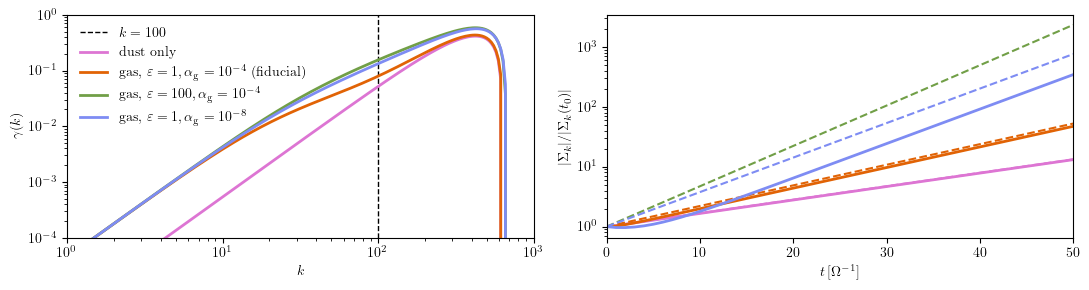

In [13]:
# %% make diffusion-slope comparison figure (EVP vs nonlinear IVP)

from diffinst.vis.linear import plot_diffusion_slope_family

configs_diff = {
    "dust":     EXP_DIFF_DUST,
    "fid":      EXP_DIFF_BASE,
    "high_eps": EXP_DIFF_HIGHEPS,
    "low_nu_g": EXP_DIFF_LOWNU_G,
}

fig, axes = plot_diffusion_slope_family(
    configs=configs_diff,
    runs_nl=RUN_DIFF_NL,
    k_phys=K_PHYS_DIFF,
    kmin=1,
    kmax=1e3,
    nk=200,
    labels=DIFF_LABELS,
    figsize=(11, 3),
)

plt.tight_layout()
plt.show()
fig.savefig(FIGURE_PATH / "linearevolution_dustvgas.pdf", bbox_inches="tight")